In [7]:
import json
import os
import pandas as pd
from collections import defaultdict
# import ace_tools as tools

# === 경로 설정 ===
json_path = "/media/hong/CC101550101542BE/keypoints/kitti_keypoints.json"
label_dir = "/media/hong/CC101550101542BE/keypoints/label_2"
train_txt = "/media/hong/CC101550101542BE/keypoints/ImageSets/train.txt"
val_txt = "/media/hong/CC101550101542BE/keypoints/ImageSets/val.txt"
save_train_json = "/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_train.json"
save_val_json = "/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_val.json"

# === Load image split lists ===
def load_image_ids(txt_path):
    with open(txt_path, "r") as f:
        return set(line.strip() + ".png" for line in f.readlines())

train_ids = load_image_ids(train_txt)
val_ids = load_image_ids(val_txt)

# === Load keypoints JSON ===
with open(json_path, "r") as f:
    keypoints_data = json.load(f)

# === Load KITTI label annotations ===
def load_kitti_labels(label_dir):
    label_dict = defaultdict(list)
    for fname in os.listdir(label_dir):
        if fname.endswith(".txt"):
            image_id = fname.replace(".txt", "") + ".png"
            with open(os.path.join(label_dir, fname), "r") as f:
                for idx, line in enumerate(f.readlines()):
                    parts = line.strip().split()
                    if len(parts) > 14:
                        label_dict[image_id].append({
                            "object_index": str(idx),
                            "type": parts[0],
                            "rotation_y": float(parts[14])
                        })
    return label_dict

kitti_labels = load_kitti_labels(label_dir)

# === Match orientation (theta) to keypoints ===
for item in keypoints_data:
    img_id = item["image_id"]
    obj_idx = item["object_index"]
    match = next((o for o in kitti_labels[img_id] if o["object_index"] == obj_idx and o["type"].lower() == "car"), None)
    item["theta"] = match["rotation_y"] if match else None

# === Split by official image sets ===
train_data = [item for item in keypoints_data if item["image_id"] in train_ids]
val_data = [item for item in keypoints_data if item["image_id"] in val_ids]

# === Save new JSON files ===
with open(save_train_json, "w") as f:
    json.dump(train_data, f, indent=2)
with open(save_val_json, "w") as f:
    json.dump(val_data, f, indent=2)

# # === 미리보기 출력 ===
# tools.display_dataframe_to_user("Example Training Entries", pd.DataFrame(train_data[:5]))

(save_train_json, save_val_json)


('/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_train.json',
 '/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_val.json')

In [8]:
import json
import os
from collections import defaultdict

# === 경로 설정 ===
json_path = "/media/hong/CC101550101542BE/keypoints/kitti_keypoints.json"
label_dir = "/media/hong/CC101550101542BE/keypoints/label_2"
train_txt = "/media/hong/CC101550101542BE/keypoints/ImageSets/train.txt"
val_txt = "/media/hong/CC101550101542BE/keypoints/ImageSets/val.txt"
save_train_json = "/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_train.json"
save_val_json = "/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_val.json"

# === 함수 정의 ===

def load_image_ids(txt_path):
    with open(txt_path, "r") as f:
        return set(line.strip() + ".png" for line in f.readlines())

def load_kitti_labels(label_dir):
    label_dict = defaultdict(list)
    for fname in os.listdir(label_dir):
        if fname.endswith(".txt"):
            image_id = fname.replace(".txt", "") + ".png"
            with open(os.path.join(label_dir, fname), "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) > 14:
                        label_dict[image_id].append({
                            "type": parts[0],
                            "bbox": list(map(float, parts[4:8])),  # [x1, y1, x2, y2]
                            "rotation_y": float(parts[14])
                        })
    return label_dict

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    box2_area = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# === 데이터 로드 ===
train_ids = load_image_ids(train_txt)
val_ids = load_image_ids(val_txt)

with open(json_path, "r") as f:
    keypoints_data = json.load(f)

kitti_labels = load_kitti_labels(label_dir)

# === theta 매칭 ===
for item in keypoints_data:
    img_id = item["image_id"]
    crop_box = item["crop_bbox"]
    best_iou = 0
    best_theta = None

    for obj in kitti_labels[img_id]:
        if obj["type"].lower() != "car":
            continue
        iou = compute_iou(crop_box, obj["bbox"])
        if iou > best_iou:
            best_iou = iou
            best_theta = obj["rotation_y"]

    # IoU가 일정 임계값 이상일 때만 매칭
    item["theta"] = best_theta if best_iou > 0.3 else None  # 0.3은 필요시 조정

# === Split by official image sets ===
train_data = [item for item in keypoints_data if item["image_id"] in train_ids]
val_data = [item for item in keypoints_data if item["image_id"] in val_ids]

# === 저장 ===
with open(save_train_json, "w") as f:
    json.dump(train_data, f, indent=2)
with open(save_val_json, "w") as f:
    json.dump(val_data, f, indent=2)

(save_train_json, save_val_json)


('/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_train.json',
 '/media/hong/CC101550101542BE/keypoints/keypoints_with_theta_val.json')

# Vis KITTI

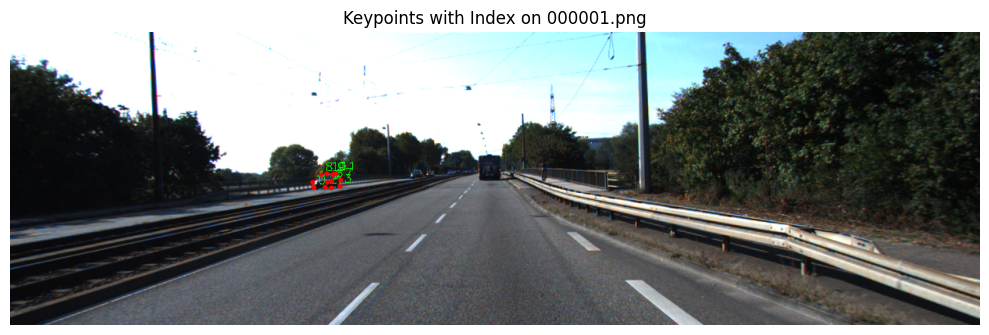

In [ ]:
import cv2
import matplotlib.pyplot as plt

# === 입력 정보 ===
image_id = "000031.png"
keypoints = [[911,301],[797,297],[993,309],[855,306],[863,248],[792,248],[1022,250],[882,251],[907,180],[833,186],[981,184],[882,185]]

# === 이미지 경로 (KITTI image_2 디렉토리 경로로 바꿔주세요) ===
image_path = f"/media/hong/CC101550101542BE/keypoints/{image_id}"

# === 이미지 불러오기 ===
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

# BGR → RGB (matplotlib용)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === 키포인트 시각화 (점 + 인덱스 표기) ===
for i, (x, y) in enumerate(keypoints):
    cv2.circle(img_rgb, (int(x), int(y)), radius=3, color=(255, 0, 0), thickness=-1)
    cv2.putText(img_rgb, str(i), (int(x)+5, int(y)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# === 출력 ===
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title(f"Keypoints with Index on {image_id}")
plt.axis('off')
plt.tight_layout()
plt.show()
